In [472]:
import os
import csv
import sys
import copy
import logging
import numpy as np
#from stats import *
import pandas as pd
import seaborn as sns
from scipy import stats
#from Layer import Layer
import tensorflow as tf 
from pandas import DataFrame
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from sklearn.model_selection import train_test_split, KFold
from sklearn.datasets import fetch_california_housing, make_regression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [473]:
def write_stats(samples, features, loss, epochs, lr, batch_size, cross_k, r2, mse_train, mae_train, residual_train):
    with open('../data/stats.csv', 'a') as f:
        newrow = [samples, features, loss, epochs, lr, batch_size, cross_k, r2, mse_train, mae_train, residual_train]
        writer = csv.writer(f)
        writer.writerow(newrow)

def fill_dataset(dataframe: DataFrame):
    for column in dataframe:
        if dataframe[column].dtype != 'object':
            dataframe[column] = dataframe[column].fillna(dataframe[column].mean())
    return dataframe

def normalize_dataset(X):
    return tf.keras.utils.normalize(X)

def remove_outliers(X, threshold=7):
    z = np.abs(stats.zscore(X))
    return X[(z<threshold).all(axis=1)][:, 0:-1], X[(z<threshold).all(axis=1)][: ,-1]

def make_dataset(X_data,y_data,k):
    X_data, y_data = remove_outliers(np.concatenate([X_data, y_data], axis=1))
    def gen():
        for train_index, test_index in KFold(k).split(X_data):
            X_train, X_test = X_data[train_index], X_data[test_index]
            XN_train, XN_test = normalize_dataset(X_data[train_index]), normalize_dataset(X_data[test_index])
            y_train, y_test = y_data[train_index], y_data[test_index]
            yield X_train,XN_train,y_train,X_test,XN_test,y_test

    return tf.data.Dataset.from_generator(gen, (tf.double,tf.double,tf.double,tf.double,tf.double,tf.double))


In [474]:
total_columns=["A", "B", "C", "D", "E", "F", "G", "H", "I", "J", "K", "L", "M", "N", "O", "P", "Q", "R", "S", "T", "U", "V", "W", "X", "Y", "Z"]
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  
k = 2
epochs = 3000
lr = 0.01
batch_size = 120

XR, yR = make_regression(n_samples=1000, n_features=2, n_informative=5, noise=50, random_state=5)
X_train, X_test, y_train, y_test = train_test_split(XR, yR, test_size=0.20, random_state=2)
columns = ["{0}".format(total_columns[i]) for i in range(XR.shape[1]+1)]
dataframe = pd.DataFrame(np.concatenate([XR, np.reshape(yR, [-1, 1])], axis=1), columns=columns)
#dataframe.drop(["REGION", "PERIODTYPE"], inplace=True, axis=1)
dataframe.head()

,A,B,C
0,-1.809551,-0.255518,-146.720873
1,-0.132302,-0.379225,-99.386666
2,0.103858,0.300797,49.885697
3,-1.812030,-0.395195,-68.451517
4,-0.865348,1.323168,-19.090309


In [475]:
vif_data = pd.DataFrame()
vif_data["features"] = dataframe.columns
vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(len(dataframe.columns))]
print(vif_data)

  features       VIF
0        A  2.525957
1        B  1.961427
2        C  3.400332


In [476]:
class Layer(tf.Module):
    def __init__(self, activation=tf.identity):
        self.activation = activation
        self.build = False
        self.normalized = False
        
    @tf.function(reduce_retracing=True)
    def xavier_init(self, shape):
        in_dim, out_dim = shape
        xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(in_dim + out_dim, tf.float32))
        weight_vals = tf.cast(tf.random.uniform(shape=(in_dim, out_dim), 
                                        minval=-xavier_lim, maxval=xavier_lim, seed=22, dtype=tf.float32), dtype=tf.double)
        #xavier_lim = tf.sqrt(6.)/tf.sqrt(tf.cast(shape, tf.float32))
        #weight_vals = tf.cast(tf.random.uniform(shape=(shape,), 
        #                                minval=-xavier_lim, maxval=xavier_lim, seed=22, dtype=tf.float32), dtype=tf.double)
        
        return weight_vals

    @tf.function
    def __call__(self, X):
        if not self.build:
            n_samples, n_features = X.shape
            self.weights = tf.Variable(self.xavier_init(shape=(n_samples, n_features)), name="Weights", dtype=tf.double, trainable=True, )

            self.bias = tf.Variable(tf.ones(shape=1, dtype=tf.double), name="Bias", dtype=tf.double, trainable=True )
            self.build = True

        z = tf.add(tf.multiply(X, self.weights), self.bias)

        #print(X.shape,"*",self.weights.shape,"+",self.bias.shape, "=", z.shape)
        return self.activation(z), self.bias


In [477]:
class CiclicAI(tf.Module):
    def __init__(self, epochs=100, lr=0.01, batch_size=50):
        self.epochs = epochs
        self.batch_counter = 0
        self.batch_size = batch_size
        self.optimizer = tf.keras.optimizers.Adam(lr=lr)
        self.compiled = False
        self.loss_history = [e for e in range(epochs)]
        self.r2_history = [e for e in range(epochs)]
    
    def verify_batch(self, X):
        if self.batch_counter >= X:
            self.batch_counter = 0

    def calc_metrics(self, e, loss, y_train, predicted_train):
        self.loss_history[e] = loss
        self.r2_history[e] = self.r2(y_train, predicted_train)

    def r2(self, y, y_pred):
        return tf.subtract(
            tf.convert_to_tensor(1, dtype=tf.float64), 
            tf.divide(
                tf.reduce_sum(tf.square(tf.subtract(y, y_pred))),
                tf.reduce_sum(tf.square(tf.subtract(y, tf.reduce_mean(y_pred))))
            )
        )
    
    @tf.function
    def lasso(self, weights):
        return tf.reduce_sum(tf.norm(weights))

    @tf.function
    def ridge(self, weights):
        return tf.reduce_sum(tf.square(tf.norm(weights)))

    @tf.function(reduce_retracing=True)
    def loss(self, y, predicted, weights):
        return tf.add(tf.add(tf.losses.MSE(y, predicted), self.lasso(weights)), self.ridge(weights))

    @tf.function(reduce_retracing=True)
    def compile(self):
        if not self.compiled:
            self.layer_reg1 = Layer(tf.nn.relu)
            self.compiled = True

    @tf.function(reduce_retracing=True)
    def _predict(self, X, coef, bias):
        return tf.reduce_mean(tf.add(tf.multiply(X, coef), bias), axis=1)

    def predict_test(self, X_test):
        self.predicted_test = self._predict(X_test, self.coef, self.bias)

    def predict(self, x):
        return self._predict(x, self.coef, self.bias)
    
    @tf.function(reduce_retracing=True)
    def _forward(self, X_train):
        return self.layer_reg1(X_train)

    @tf.function(reduce_retracing=True)
    def _backprop(self, weights, X_train, y_train):
        weights, bias = self._forward(weights)
        coef = tf.reduce_mean(tf.add(tf.matmul(tf.transpose(X_train[self.batch_counter:self.batch_counter+self.batch_size]), weights), bias), axis=0)
        predicted = self._predict(X_train, coef, bias)

        return self.loss(y_train, predicted, weights), coef, bias, predicted

    def fit(self, X_train, y_train):
        self.verify_batch(X_train.shape[0])
        weights = normalize_dataset(X_train[self.batch_counter:self.batch_counter+self.batch_size])
        for e in range(self.epochs):
            with tf.GradientTape(watch_accessed_variables=True, persistent=True) as tape:
                loss, self.coef, self.bias, self.predicted_train = self._backprop(weights, X_train, y_train)

            self.vars = [self.layer_reg1.weights, self.layer_reg1.bias]
            grads = tape.gradient(loss, self.vars)  
            self.optimizer.apply_gradients(zip(grads, self.vars))   
            self.calc_metrics(e, loss, y_train, self.predicted_train)
            self.batch_counter = self.batch_counter + self.batch_size

            if(e%50==0):
                print("[{0}] Loss: {1}, R2: {2}, Coef: {3}, Bias: {4}".format(e, loss, self.r2_history[e], self.coef, self.bias))


In [478]:
model = CiclicAI(epochs, lr, batch_size)
model.compile()
model.fit(X_train, y_train)
model.predict_test(X_test)

c:\Users\Utente\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


[0] Loss: 8304.862296354382, R2: 0.04182168164788724, Coef: [3.08982964 3.90157728], Bias: [1.]
[50] Loss: 6434.469954129471, R2: 0.24828222370095043, Coef: [21.22876092 23.94886347], Bias: [0.57931038]
[100] Loss: 5291.838394106387, R2: 0.40272234594161316, Coef: [38.29283275 41.88503614], Bias: [0.83338432]
[150] Loss: 4626.238760278103, R2: 0.5007013968723321, Coef: [52.14876564 55.38651663], Bias: [1.04075005]
[200] Loss: 4241.805303067074, R2: 0.5615590908282254, Coef: [63.21754355 64.74839991], Bias: [1.18163558]
[250] Loss: 4012.70867136735, R2: 0.5994437553323599, Coef: [71.80702522 71.09097438], Bias: [1.26701679]
[300] Loss: 3867.7927298313743, R2: 0.6232551944546116, Coef: [78.43813066 75.07256499], Bias: [1.31080669]
[350] Loss: 3766.5399902004365, R2: 0.6385030893822319, Coef: [83.55432306 77.36919238], Bias: [1.32060969]
[400] Loss: 3697.280192452908, R2: 0.6493906680438476, Coef: [87.63950845 79.1801046 ], Bias: [1.33173815]
[450] Loss: 3649.7607513615667, R2: 0.65702860

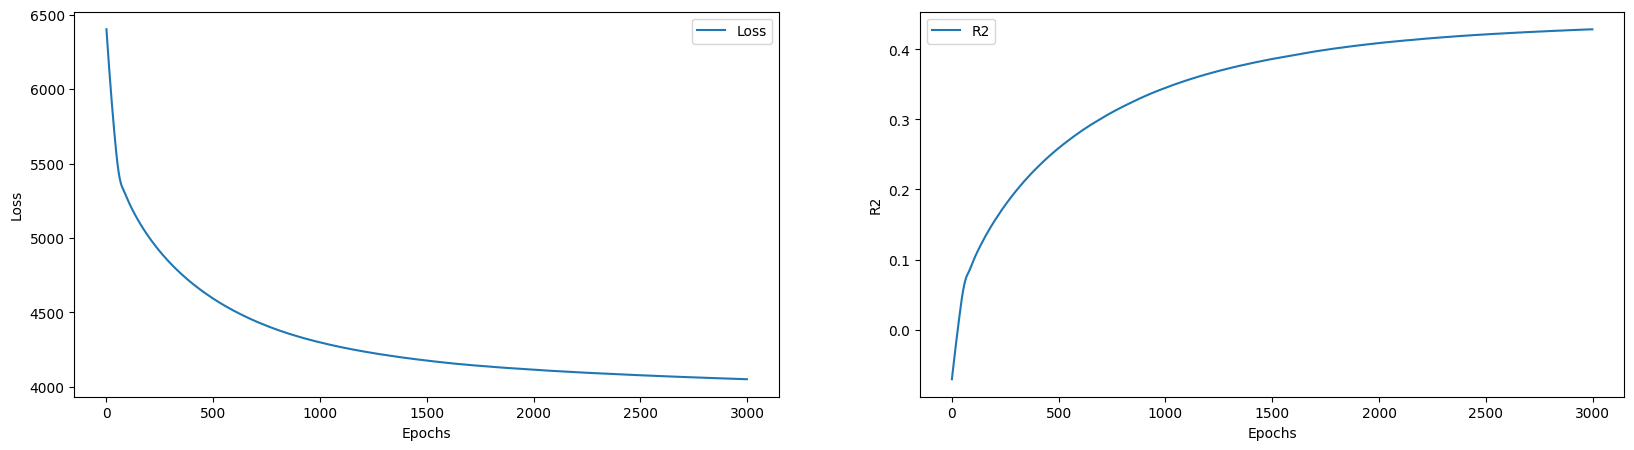

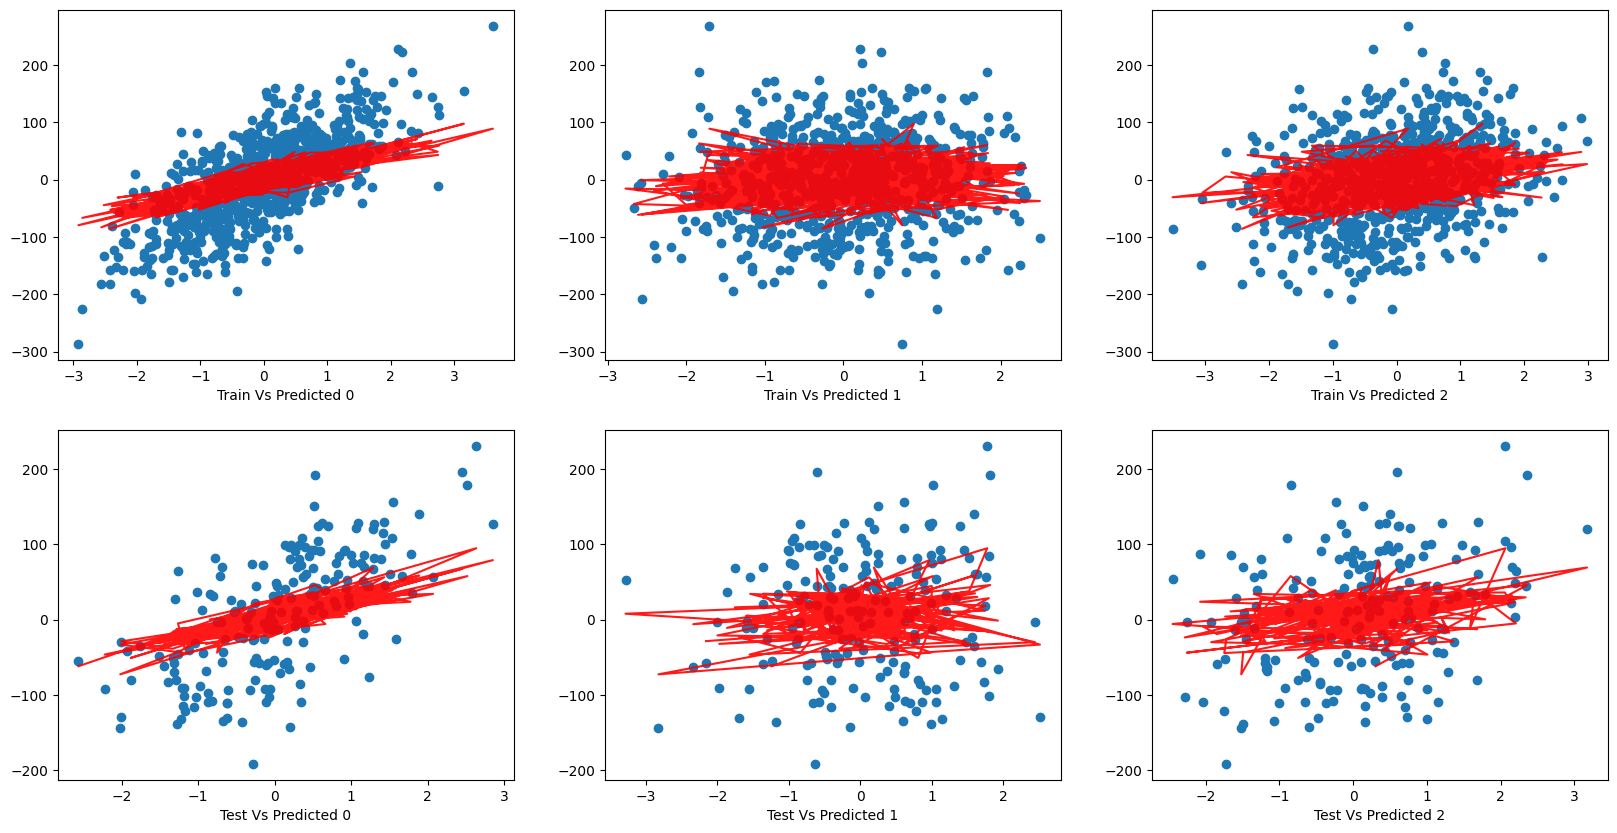

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].plot([e for e in range(epochs)], model.loss_history, label="Loss")
ax[0].set_ylabel('Loss')
ax[0].set_xlabel('Epochs')
ax[0].legend()

ax[1].plot([e for e in range(epochs)], model.r2_history, label="R2")
ax[1].set_ylabel('R2')
ax[1].set_xlabel('Epochs')
ax[1].legend()


fig2, ax2 = plt.subplots(2, X_train.shape[1], figsize=(20, 10))
for i in range(X_train.shape[1]):
    if X_train.shape[1] == 1:
        ax2[0].scatter(X_train[:], y_train[:], cmap='viridis')
        ax2[0].plot(X_train[:], model.predicted_train[:], color='r', zorder = 10, alpha = 0.9)
        #ax2[0].set_ylim([-300, 300])
        #ax2[0].set_xlim(-3,3)
        ax2[0].set_xlabel("Train Vs Predicted {0}".format(i))

        ax2[1].scatter(X_test[:], y_test[:], cmap='viridis')
        ax2[1].plot(X_test[:], model.predicted_test[:], color='r', zorder = 10, alpha = 0.9)
        #ax2[1].set_ylim([-200, 200])
        #ax2[1].set_xlim(-3,3)
        ax2[1].set_xlabel("Test Vs Predicted {0}".format(i))

    else:
        ax2[0, i].scatter(X_train[:, i], y_train[:], cmap='viridis')
        ax2[0, i].plot(X_train[:, i], model.predicted_train[:], color='r', zorder = 10, alpha = 0.9)
        #ax2[0, i].set_ylim([-300, 300])
        #ax2[0, i].set_xlim(-3,3)
        ax2[0, i].set_xlabel("Train Vs Predicted {0}".format(i))

        ax2[1, i].scatter(X_test[:, i], y_test[:], cmap='viridis')
        ax2[1, i].plot(X_test[:, i], model.predicted_test[:], color='r', zorder = 10, alpha = 0.9)
        #ax2[1, i].set_ylim([-200, 200])
        #ax2[1, i].set_xlim(-3,3)
        ax2[1, i].set_xlabel("Test Vs Predicted {0}".format(i))